1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

--2023-12-08 17:36:10--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2023-12-08 17:36:10--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a8b304046f3903ea7d917d0af.dl.dropboxusercontent.com/cd/0/inline/CJCTUxJezKfFR49NWwWueV5rsljeQtMnRpTk8xR26RB6bjHHk6zyGVzSCpJgTRbHHANbQdXAI8XkuLTl_OOEeVy4j7TbdKclp8FDuxu53fhO2fVWVH1tL5wTibTtRu87K4o/file# [following]
--2023-12-08 17:36:11--  https://uc8a8b304046f3903ea7d917d0af.dl.dropboxusercontent.com/cd/0/inline/CJCTUxJezKfFR49NWwWueV5rsljeQtMnRpTk8xR26RB6bjHHk6zyGVzSCpJgTRbHHANbQdXAI8XkuLTl_OOEeVy4j7TbdKclp8FDuxu53fhO2fV

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
#file name
fn = "data/data_000637.txt"
data = pd.read_csv(fn)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
#drop the duplicates
filtered_data = data.drop_duplicates(subset='ORBIT_CNT', keep='last')
bx_estimation = filtered_data.BX_COUNTER.mean()
print("Estimation of the number of BX in a ORBIT:",bx_estimation)

Estimation of the number of BX in a ORBIT: 3278.7756567584765


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [4]:
#as suggested, intruduction of the offsets
offset_orbit = data["ORBIT_CNT"] - data["ORBIT_CNT"].loc[0]
offset_bx_counter = data["BX_COUNTER"] - data["BX_COUNTER"].loc[0]
offset_tdc_meas = data["TDC_MEAS"] - data["TDC_MEAS"].loc[0]

data["ABSOLUTE_TIME"] = offset_orbit*bx_estimation*25 + offset_bx_counter*25 + offset_tdc_meas
data["ABSOLUTE_TIME"] = pd.to_datetime(data["ABSOLUTE_TIME"])
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,1970-01-01 00:00:00.000000001
2,1,0,63,3869200167,2553,28,1970-01-01 00:00:00.000004477
3,1,0,64,3869200167,2558,19,1970-01-01 00:00:00.000004593
4,1,0,64,3869200167,2760,25,1970-01-01 00:00:00.000009649
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,1970-01-01 00:00:00.901950871
1310716,1,1,4,3869211171,763,11,1970-01-01 00:00:00.901950893
1310717,1,0,64,3869211171,764,0,1970-01-01 00:00:00.901950907
1310718,1,0,139,3869211171,769,0,1970-01-01 00:00:00.901951032


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
print(pd.to_datetime(data['ABSOLUTE_TIME']).dt.time)

0                 00:00:00
1                 00:00:00
2          00:00:00.000004
3          00:00:00.000004
4          00:00:00.000009
                ...       
1310715    00:00:00.901950
1310716    00:00:00.901950
1310717    00:00:00.901950
1310718    00:00:00.901951
1310719    00:00:00.901950
Name: ABSOLUTE_TIME, Length: 1310720, dtype: object


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
data.groupby('TDC_CHANNEL').size().sort_values(ascending=False).head(3)

TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
n = abs((filtered_data["ORBIT_CNT"] > 1).sum()) - 1
print("Non-empty orbits:", n)


Non-empty orbits: 11000


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
mask = data['TDC_CHANNEL']==139
filtered_data = data[mask]
result = filtered_data.groupby("ORBIT_CNT")["TDC_CHANNEL"].unique()
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139:",len(result))

Number of unique orbits with at least one measurement from TDC_CHANNEL=139: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
#first serie
mask = data['FPGA']==0
filtered_data = data[mask]
counts = filtered_data['TDC_CHANNEL'].value_counts().to_dict()
sr1 = pd.Series(counts, index=counts, dtype=float)
print(sr1)

#second serie
mask = data['FPGA']==1
filtered_data = data[mask]
counts = filtered_data['TDC_CHANNEL'].value_counts().to_dict()
sr2 = pd.Series(counts, index=counts, dtype=float)
print(sr2)

139    75617.0
64     64581.0
63     63724.0
61     48699.0
62     48275.0
        ...   
130       33.0
137       32.0
30         4.0
129        2.0
39         1.0
Length: 124, dtype: float64
2      32669.0
139    32442.0
1      28438.0
4      26403.0
3      21970.0
        ...   
9         80.0
130       38.0
138       36.0
137       36.0
129       35.0
Length: 132, dtype: float64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

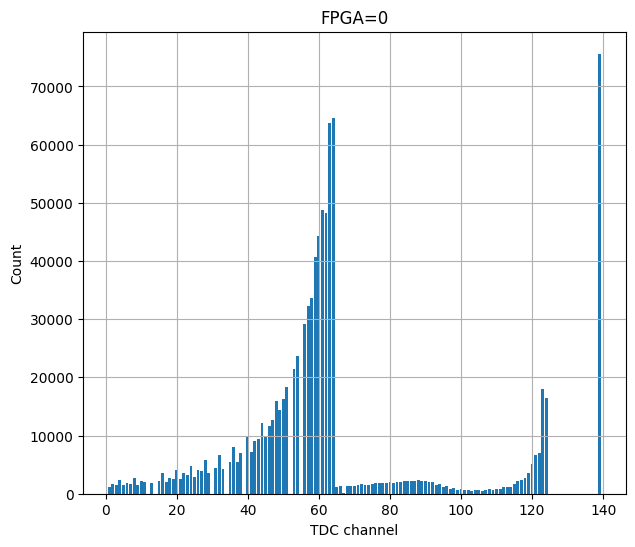

In [10]:
rcParams['figure.figsize'] = 7,6
plt.bar(sr1.index, sr1.values)
plt.xlabel('TDC channel')
plt.ylabel('Count')
plt.title('FPGA=0')
plt.grid()

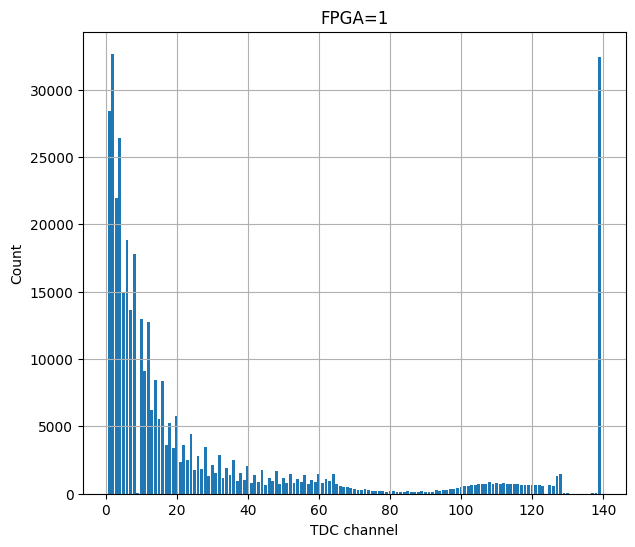

In [11]:
rcParams['figure.figsize'] = 7,6
plt.bar(sr2.index, sr2.values)
plt.xlabel('TDC channel')
plt.ylabel('Count')
plt.title('FPGA=1')
plt.grid()